In [131]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.backend import backend as k
from tensorflow.keras.callbacks import History
from tensorflow.keras.applications.vgg16 import VGG16
import cv2
import itertools
import os
import numpy as np
import pandas as pd
import shutil
import random
import glob
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
print('Importing Done')

Importing Done


In [132]:
X=[]
Y=[]

for file in next(os.walk(r'D:\Tensorflow\Salt\images'))[2]:
    image=cv2.imread(r'D:\Tensorflow\Salt\images/'+ file)
    image =cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image=cv2.resize(image,(128,128), interpolation = cv2.INTER_NEAREST)
    x=np.array(resized_image)
    x=x.astype('float32')
    x=x/255

    image1=cv2.imread(r'D:\Tensorflow\Salt\masks/'+ file)
    image1 =cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    resized_image1=cv2.resize(image1,(128,128), interpolation = cv2.INTER_NEAREST)
    y=np.array(resized_image1)
    y=y.astype('float32')
    y=y/255
    
    X.append(x)
    Y.append(y)

Text(0.5, 1.0, 'Salt')

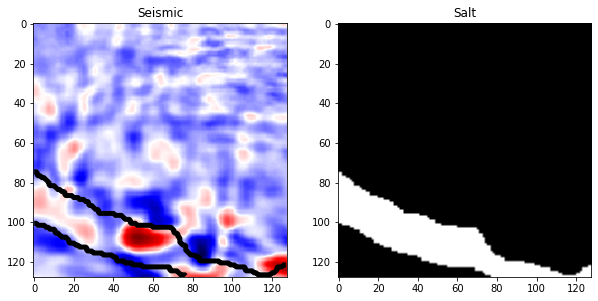

In [134]:
# Visualize any random image along with the mask
ran = random.randint(0, len(X)) # generates random integer between 0 to total number of files present in training files
has_mask = Y[ran].max()  # If there is any salt indicator the value will be more than 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.imshow(X[ran], cmap = 'seismic', interpolation = 'bilinear')
ax1.set_title('Seismic')
if has_mask>0: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(Y[ran], colors = 'k', linewidths = 5, levels = [0.5])

ax2.imshow(Y[ran], cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [135]:
X=np.asarray(X)
Y=np.asarray(Y)

In [136]:
X.shape

(4000, 128, 128)

In [137]:
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
Y=Y.reshape(Y.shape[0],Y.shape[1],Y.shape[2],1)

In [138]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1)

In [139]:
X_train.shape

(3600, 128, 128, 1)

In [146]:
def plt_train_val_acc(x,val_acc,train_acc,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_acc,'b',label="Validation Accuracy")
    plt.plot(x,train_acc,'r',label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy after each epoch')
    plt.legend()
    
def plt_train_val_loss(x,val_loss,train_loss,colors=['b']):
    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(x,val_loss,'b',label="Validation Loss")
    plt.plot(x,train_loss,'r',label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Binary Crossentropy loss')
    plt.legend()

In [140]:
def UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    
    c1 = Conv2D(16, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = BatchNormalization()(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
#-----------------------------------------------------------------------------------------------------------------    
    
    c2 = Conv2D(32, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    
    c2 = Conv2D(32, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2) 
#-----------------------------------------------------------------------------------------------------------------    
    
    c3 = Conv2D(64, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    
    c3 = Conv2D(64, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c4 = Conv2D(128, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    
    c4 = Conv2D(128, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = BatchNormalization()(c4)
   
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c5 = Conv2D(256, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    
    c5 = Conv2D(256, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = BatchNormalization()(c5)
    
    
#------UMSAMPLE STARTS---------------------------------------------------------------------------------------------

    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = Conv2D(128, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    
    c6 = Conv2D(128, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
    
    
#---------------------------------------------------------------------------------------------------

    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = Conv2D(64, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    
    c7 = Conv2D(64, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = BatchNormalization()(c7)
    
    
#---------------------------------------------------------------------------------------------------

    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = Conv2D(32, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    
    c8 = Conv2D(32, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = BatchNormalization()(c8)
    
    
#---------------------------------------------------------------------------------------------------

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = Conv2D(16, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    
    c9 = Conv2D(16, kernel_size = (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
    c9 = BatchNormalization()(c9)
    
    
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

 
    
    model = Model(input_img, outputs)
    return model

In [141]:
input_img = Input((128, 128, 1), name='img')
model = UNet(input_img)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 128, 128, 16) 64          conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_72[0][0]     
____________________________________________________________________________________________

In [115]:
os.chdir(r'D:\Tensorflow\Salt')

In [142]:
hist=History()
filepath=r'D:\Tensorflow\Salt\model/UNets-{epoch:02d}.hdf5'
save=ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,save_weights_only=False, mode='auto')

In [143]:
results = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=50, callbacks=[hist,save], verbose=2)                  

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 - 34s - loss: 0.4901 - acc: 0.8042 - val_loss: 215.1171 - val_acc: 0.2342
Epoch 2/50
3600/3600 - 27s - loss: 0.3555 - acc: 0.8717 - val_loss: 2.8222 - val_acc: 0.5107
Epoch 3/50
3600/3600 - 27s - loss: 0.2775 - acc: 0.8981 - val_loss: 0.8702 - val_acc: 0.6093
Epoch 4/50
3600/3600 - 27s - loss: 0.2604 - acc: 0.8991 - val_loss: 0.2208 - val_acc: 0.9245
Epoch 5/50
3600/3600 - 27s - loss: 0.2323 - acc: 0.9124 - val_loss: 0.2862 - val_acc: 0.9102
Epoch 6/50
3600/3600 - 27s - loss: 0.2215 - acc: 0.9137 - val_loss: 0.1748 - val_acc: 0.9330
Epoch 7/50
3600/3600 - 27s - loss: 0.2132 - acc: 0.9179 - val_loss: 0.2209 - val_acc: 0.9199
Epoch 8/50
3600/3600 - 27s - loss: 0.1950 - acc: 0.9261 - val_loss: 0.1609 - val_acc: 0.9399
Epoch 9/50
3600/3600 - 27s - loss: 0.1962 - acc: 0.9246 - val_loss: 0.1768 - val_acc: 0.9359
Epoch 10/50
3600/3600 - 27s - loss: 0.1840 - acc: 0.9302 - val_loss: 0.2289 - val_acc: 0.9201
Epoch 11/50
3600/360

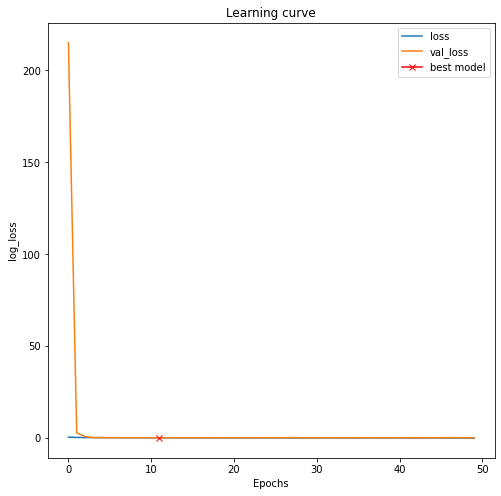

In [206]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

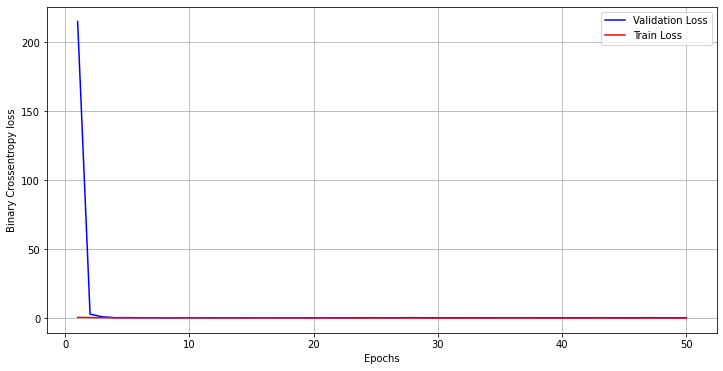

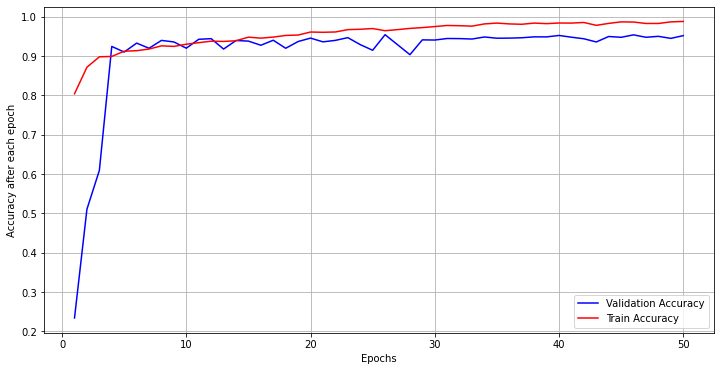

In [149]:
history=model.history
epochs=50
x=list(range(1,epochs+1))
val_loss=history.history['val_loss']
train_loss=history.history['loss']
plt_train_val_loss(x,val_loss,train_loss)

val_acc=history.history['val_acc']
train_acc=history.history['acc']
plt_train_val_acc(x,val_acc,train_acc)

In [145]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

400/400 [==============================] - 1s 2ms/sample


In [170]:
preds_train.shape

(3600, 128, 128, 1)

In [209]:
def plot_sample(X, y, preds):
    """Function to plot the results"""
    
    ran = random.randint(0, len(X))      #generates a random number

    has_mask = y[ran].max()               #squeeze help us to draw images from 3d to 2d

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ran], cmap='seismic')
    if has_mask>0:
        ax[0].contour(y[ran].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ran].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ran].squeeze(), vmin=0, vmax=1)
    if has_mask>0:
        ax[2].contour(y[ran].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    

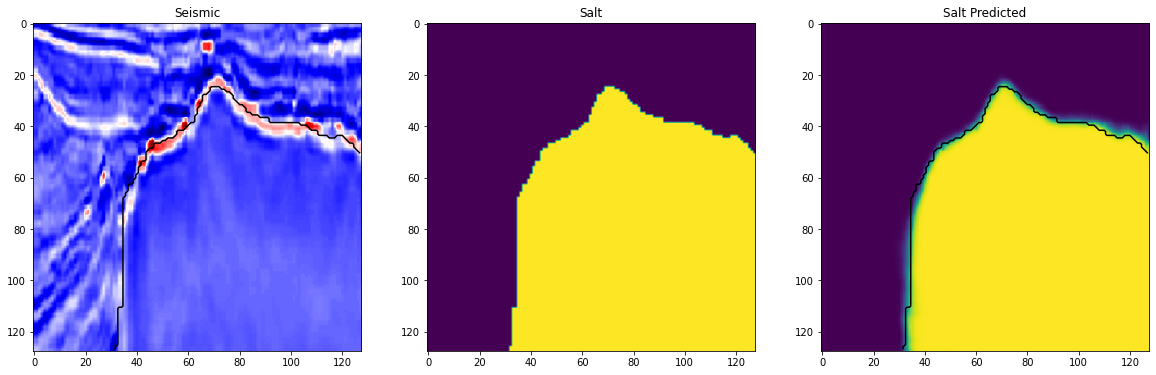

In [211]:
plot_sample(X_train, y_train, preds_train)   # This is on training data

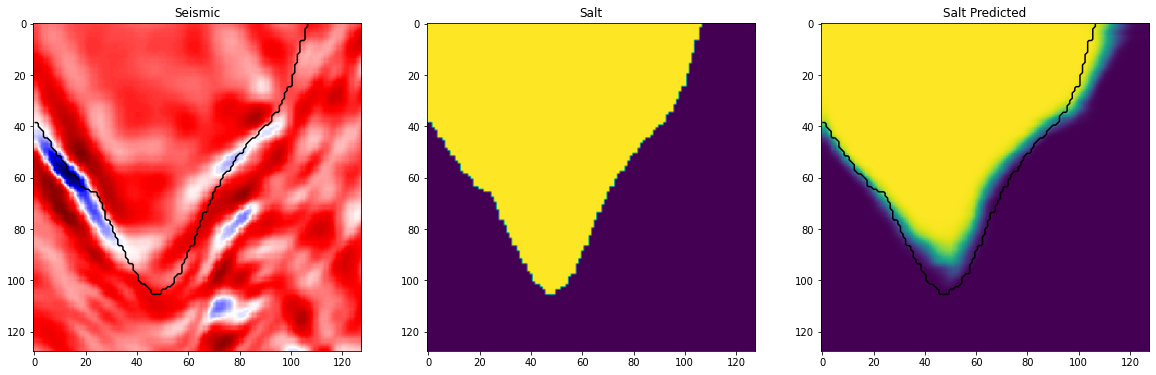

In [212]:
plot_sample(X_valid, y_valid, preds_val) # this is on testing data